# Are You The One? Analysis


## Introduction

I've never been the type to watch reality TV shows, but that changed when my girlfriend introduced me to "Are You the One?". It's a dating show that airs on MTV and follows a group of single men and women who are brought together in a tropical location to find their perfect match. The catch is that the contestants aren't told who their perfect match is, and they must figure it out for themselves through challenges and group dates. The show uses a matchmaking algorithm to pair the contestants, and each week they go on dates and reveal to the group whether they think they've found their perfect match.

Each week, the contestants can send one couple to the truth booth, a special location in the house where they can find out if they're a perfect match. Couples that are perfect matches are removed from the game. At the end of the week, they must guess the correct pairings. They are then told the number of correct matches but they do not know which are correct. If they guess all the matches correctly, they win. However, if they don't guess any matches correctly, it results in a blackout, which decreases the total prize pool by $250,000 as punishment.

This show sparked my curiosity and made me wonder if there's an optimal strategy to play the game and if it can be consistently beaten from a purely mathematical standpoint, without even considering the compatibility of the couples. In this analysis, I will be using the season 4 rules with the following parameters:

- 10 men and 10 women
- 10 rounds total
- $1,000,000 prize pool
- Each blackout results in a reduction of $250,000

## Game Setup

At the start of the game, there are 10! or 3628800 different combinations of couples to choose from. It may seem impossible to find the one correct combination from this large pool, but you'll see that the number of possible couples quickly decreases as the rounds progress. To set up the game, I will start by creating a list of sets containing all possible matchups. This only needs to be created once and can be accessed every time we play the game to reduce computation time. I experimented with using a bitboard-like numpy array to keep track of the couples, but I found that a list of sets was quicker for the operations that I was doing.

I started by creating a list of all the possible individual pairs. From there, I found all possible pairings by solving the n rook problem. Each solution corresponds to a possible pairing. An example solution is shown below. The x on the board indicate a couple and guarantees that each man and woman is only used once per solution. We can see why there are 10! solutions using this visualization as well. In the top row, we can select 10 different couples, but the number of selections decreases by 1 for every row.

```
        W O M E N
   |a|b|c|d|e|f|g|h|i|j|
  A| |x| | | | | | | | |
  B|x| | | | | | | | | |
  C| | |x| | | | | | | |
M D| | | | | | | | | |x|
E E| | | | | | | | |x| |
N F| | | | | |x| | | | |
  G| | | | | | | |x| | |
  H| | | | |x| | | | | |
  I| | | |x| | | | | | |
  J| | | | | | |x| | | |

```

The pairing pool will be decreased using the following rules. If a correct couple is selected for the truth booth, only the pairings containing that couple will be kept. If an incorrect couple is selected, the pairings that do not contain that couple will be kept. For the matchup ceremony, we need to calculate the length of the set intersections between the chosen pairing and the correct pairing and call it n. We can then check the chosen pair and each pairing in the pool and keep the pairs that have n intersections.

In [31]:
import itertools
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
np.set_printoptions(suppress=True)

In [2]:
# List of contestants

boys = ['Aaron', 'Bruno', 'Caleb', 'David', 'Ethan',
        'Frank', 'Gavin', 'Harry', 'Isaac', 'Jacob']
        
girls = ['Alice', 'Bella', 'Chloe', 'Diana', 'Emily',
        'Fiona', 'Grace', 'Haley', 'Ivory', 'Julia']

In [48]:
# All pairs
pairs = list(itertools.product(boys, girls))
pairs_index = dict()

for i, p in enumerate(pairs):
    pairs_index[i] = p


In [95]:
# Functions for the game

def couple_decoder(np_array):
    res = set()
    i = 0
    for j in np_array:
        if j == 1:
            res.add(pairs_index[i])
        i += 1

    return res


def set_find_hits(a, b):
    return len(list(a.intersection(b)))

    
def set_reduce_truth(all_pairs, truth_bool, truth):
    return [j for j in all_pairs if (truth in j) == truth_bool]


def set_reduce_match(all_pairs, p, hit):
    return [j for j in all_pairs if len(list(p.intersection(j))) == hit]


def solveNRooks(n=10):
        state = np.zeros(n*n, dtype=int)
        res = []
        ans = []
    
        visited_cols=set()

        def backtrack(r):
            if r==n:                
                res.append(state.copy())
                ans.append(couple_decoder(res[-1]))
                return
            
            for c in range(n):
                if not c in visited_cols:                    
                    visited_cols.add(c)
                    state[(n * r + c)] = 1
                    backtrack(r+1) 

                    visited_cols.remove(c)
                    state[(n * r + c)] = 0
                                                
        backtrack(0)
        return ans


In [96]:
unique_combos_set = solveNRooks(10)

## Random Approach

In the random approach, the truth booth selection and the match up selection will be chosen at complete random. This will be the baseline of the experiment and I will see if I can improve upon this result.

In [123]:
def random_game(turns=10):
    all_combos = unique_combos_set.copy()
    ans = random.choice(unique_combos_set)

    win, combinations, hits, prize, blackouts = 0, [np.nan]*10, [np.nan]*10, 1000000, [np.nan]*10
    matches = []
    unconfirmed = pairs.copy()
    # main game loop
    for i in range(turns):
        
        # Select couple for Truth Booth
        truth_choice = random.choice(unconfirmed)
        unconfirmed.remove(truth_choice)
        
        # Eliminate combinations that do not fit Truth Booth result
        all_combos = set_reduce_truth(all_combos, truth_choice in ans, truth_choice)
        if truth_choice in ans:
            matches.append(truth_choice)
        # Choose matchup at random from remaining pool
        choice = random.choice(all_combos)
        hits[i] = set_find_hits(ans, choice)

        # Eliminate combinations that do not fit the match up result
        all_combos = set_reduce_match(all_combos, choice, hits[i])
        combinations[i] = len(all_combos)
        if hits[i] == 10:
            win = 1
            break
        elif hits[i] <= len(matches):
            prize -= 250000
            blackouts[i] = 1
            if prize <= 0:
                break
        else:
            blackouts[i] = 0
        
    combinations.insert(0, 3628800)
    
    if win == 0:
        prize = 0

    return win, combinations, hits, prize, blackouts



In [124]:
# Data
random_win = []
random_combinations = []
random_hits = []
random_prize = []
random_blackouts = []

In [125]:
number_games = 100
for _ in range(number_games):
    _win, _combination, _hits, _prize, _blackouts = random_game()
    
    random_win.append(_win)
    random_combinations.append(_combination)
    random_hits.append(_hits)
    random_prize.append(_prize)
    random_blackouts.append(_blackouts)


### Random Results

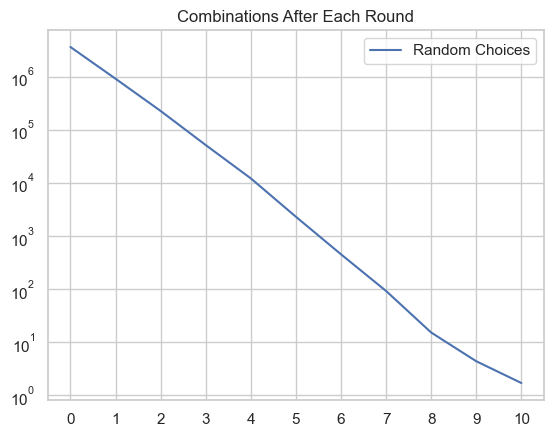

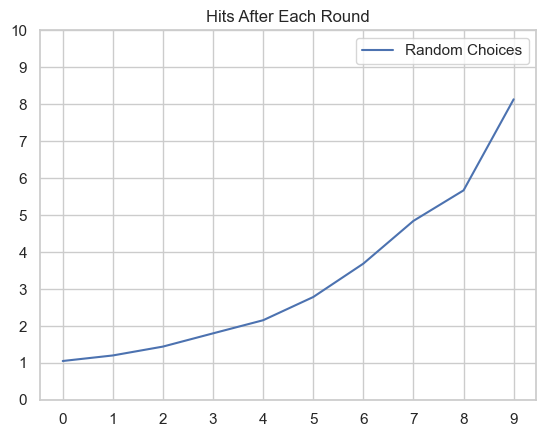

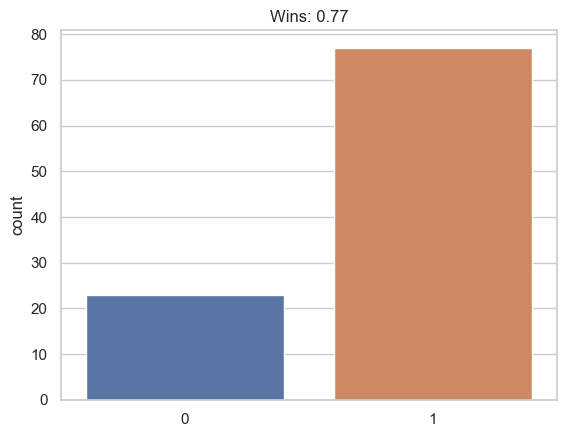

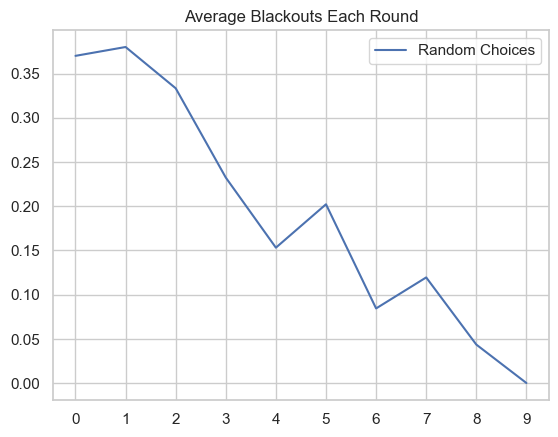

In [127]:
plt.yscale("log") 
plt.plot(np.nanmean(np.array(random_combinations), axis=0), label='Random Choices')
plt.title('Combinations After Each Round')
plt.xticks(np.arange(0, 11, 1))
plt.legend()
plt.show()


plt.plot(np.nanmean(np.array(random_hits),axis=0), label='Random Choices')
plt.title('Hits After Each Round')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 11, 1))
plt.legend()
plt.show()

sns.countplot(x=random_win)
plt.title(f'Wins: {sum(random_win)/len(random_win)}')
plt.show()

plt.plot(np.nanmean(np.array(random_blackouts),axis=0), label='Random Choices')
plt.title('Average Blackouts Each Round')
plt.xticks(np.arange(0, 10, 1))
plt.legend()
plt.show()

Surprisingly, the results show that playing the game at random is actually not a bad strategy. Out of 100 games, this method was able to win 74 times. The first graph is on a logarithmic scale and we can see that the number of possible couples decreases exponentially, but it does not reach 1 by the end of the last round. We would want this graph to reach 1 by the time we are making our final choice to guarantee a win everytime. 

## Minimax

One problem with the random approach is that the results can vary drastically depending on the roll you get. For example, if you select a couple that is in 1 out of 100 possible pairings, you could either reduce the number of possible pairings to 1 or 99, depending on the result of the truth booth. It's a similar case for the matchup ceremony as well. In order to consistently reduce the pool size, we want to choose the couple and matchup that will reduce the pool the most in the worst case.

We can use a minimax-like algorithm to achieve this, where we rank each decision by the worst score and choose decision with the best score. For the truth booth, we look at how the pairing pool would be reduced if the couple is a perfect match and if they're not. The score for that couple is the maximum of those two numbers. Once we compute the result for all couples, we then take the minimum of the scores and select the corresponding couple for the truth booth. For the matchup ceremony, for each pairing left in the pool, we check how the pool would be reduced for 0 hits through 10 hits. The score for the pairing will be the maximum of these scores. Once the scores are calculated for each pairing, we take the minimum of these scores and select them for the matchup ceremony.

I was initially going to run the algorithm for all of the rounds for all pairings in the pool, but the computation time was not realistic. After researching, I found that Hennie de Harder did a similar project ([Link to Article](https://towardsdatascience.com/solving-mtvs-are-you-the-one-is-it-possible-to-never-lose-992488277099)) and used a sampling method when the pool size is very large. There is little need to check all of the options in early rounds because the results for each pairing are very similar, so computation time can be reduced without much change to performance. So when the pool size is very large, I will select a sample of the pool to run the algorithm on. This should improve simulation time without changing the results too much.

In [155]:
# Minimax Algorithm
def truth_booth(all_pairs, possible_couples):
    scores = []
    for i in possible_couples:
        scores.append(max(len(set_reduce_truth(all_pairs, True, i)), len(set_reduce_truth(all_pairs, False, i))))
    
    return possible_couples[scores.index(min(scores))]

def match_up(all_pairs):
    if len(all_pairs) > 10000:
        sample = random.sample(all_pairs, 10)
    elif len(all_pairs) > 1000:
        sample = random.sample(all_pairs, 100)
    else:
        sample = all_pairs.copy()
    scores = []
    for i in sample:
        temp = []
        for j in range(9):
            temp.append(len(set_reduce_match(sample, i, j)))
        scores.append(max(temp))

    return sample[scores.index(min(scores))]



In [156]:
def minimax_game(turns=10):
    all_combos = unique_combos_set.copy()
    ans = random.choice(unique_combos_set)

    win, combinations, hits, prize, blackouts = 0, [np.nan]*10, [np.nan]*10, 1000000, [np.nan]*10
    matches = []
    unconfirmed = pairs.copy()
    # main game loop
    for i in range(turns):
        
        # Select couple for Truth Booth
        if i == 0:
            truth_choice = random.choice(unconfirmed)
        else:
            truth_choice = truth_booth(all_combos, unconfirmed)
        unconfirmed.remove(truth_choice)
        
        # Eliminate combinations that do not fit Truth Booth result
        all_combos = set_reduce_truth(all_combos, truth_choice in ans, truth_choice)
        if truth_choice in ans:
            matches.append(truth_choice)

        # Choose matchup from remaining pool
        choice = match_up(all_combos)
        hits[i] = set_find_hits(ans, choice)

        # Eliminate combinations that do not fit the match up result
        all_combos = set_reduce_match(all_combos, choice, hits[i])
        combinations[i] = len(all_combos)
        if hits[i] == 10:
            win = 1
            break
        elif hits[i] <= len(matches):
            prize -= 250000
            blackouts[i] = 1
            if prize <= 0:
                break
        else:
            blackouts[i] = 0
        
    combinations.insert(0, 3628800)
    
    if win == 0:
        prize = 0

    return win, combinations, hits, prize, blackouts

In [157]:
minimax_win = []
minimax_combinations = []
minimax_hits = []
minimax_prize = []
minimax_blackouts = []

In [158]:
number_games = 100
for _ in range(number_games):
    _win, _combination, _hits, _prize, _blackouts = minimax_game()
    
    minimax_win.append(_win)
    minimax_combinations.append(_combination)
    minimax_hits.append(_hits)
    minimax_prize.append(_prize)
    minimax_blackouts.append(_blackouts)

### Results

In [159]:
# Create Dataframe

random_DF = pd.DataFrame({'Wins': random_win, 'Combinations': random_combinations, 
                        'Hits': random_hits, 'Prize': random_prize, 'Blackouts': random_blackouts, 'Strategy': 'Random'})
minimax_DF = pd.DataFrame({'Wins': minimax_win, 'Combinations': minimax_combinations, 
                        'Hits': minimax_hits, 'Prize': minimax_prize, 'Blackouts': minimax_blackouts,'Strategy': 'Minimax'})

all_games = pd.concat([random_DF, minimax_DF], axis=0)


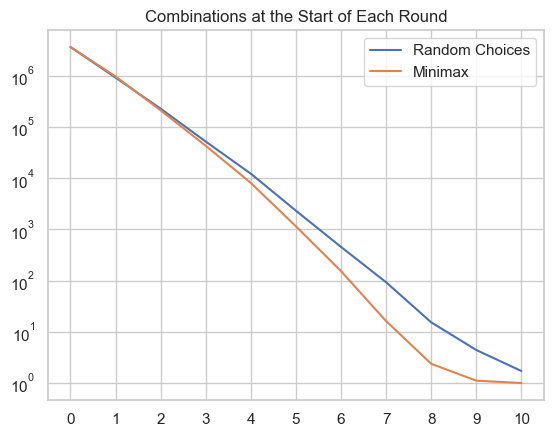

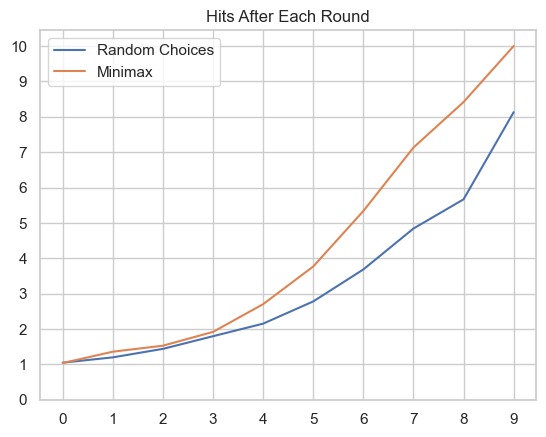

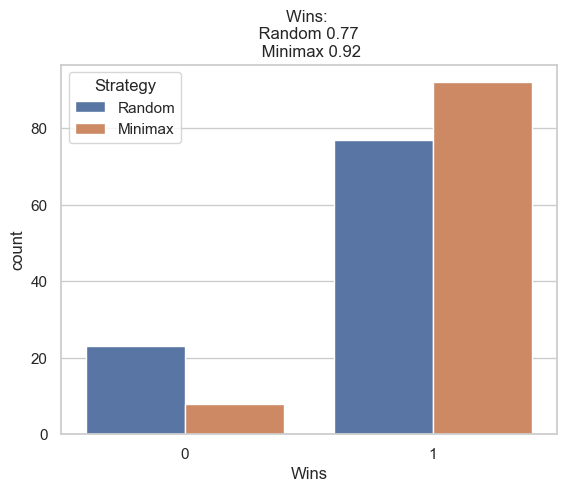

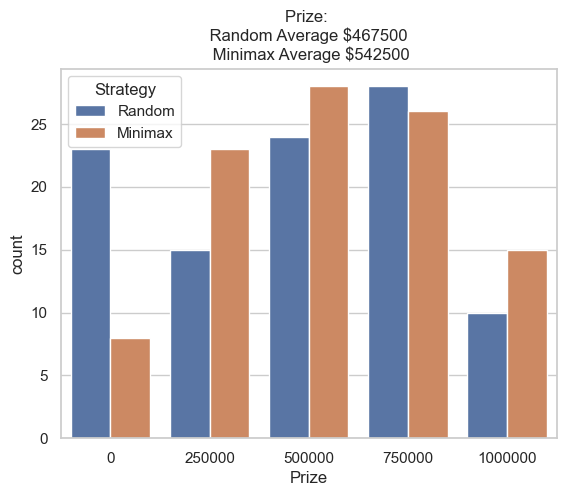

/var/folders/73/rf4v9r3n227g6d0trl9cp3gc0000gn/T/ipykernel_93507/4130050378.py:27: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(np.array(minimax_blackouts),axis=0), label='Minimax')


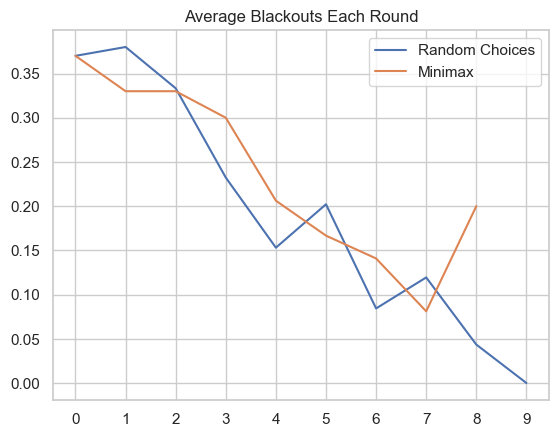

In [163]:
plt.yscale("log") 
plt.plot(np.nanmean(np.array(random_combinations), axis=0), label='Random Choices')
plt.plot(np.nanmean(np.array(minimax_combinations), axis=0), label='Minimax')
plt.title('Combinations at the Start of Each Round')
plt.xticks(np.arange(0, 11, 1))
plt.legend()
plt.show()


plt.plot(np.nanmean(np.array(random_hits),axis=0), label='Random Choices')
plt.plot(np.nanmean(np.array(minimax_hits),axis=0), label='Minimax')
plt.title('Hits After Each Round')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 11, 1))
plt.legend()
plt.show()

sns.countplot(data=all_games, x="Wins", hue="Strategy")
plt.title(f'Wins: \n Random { sum(random_DF.Wins) / len(random_DF.Wins)} \n Minimax { sum(minimax_DF.Wins) / len(minimax_DF.Wins)}')
plt.show()

sns.countplot(data=all_games, x="Prize", hue="Strategy")
plt.title(f'Prize: \n Random Average ${round(sum(random_DF.Prize) / len(random_DF.Prize))} \n Minimax Average ${round(sum(minimax_DF.Prize) / len(minimax_DF.Prize))}')
plt.show()

plt.plot(np.nanmean(np.array(random_blackouts),axis=0), label='Random Choices')
plt.plot(np.nanmean(np.array(minimax_blackouts),axis=0), label='Minimax')
plt.title('Average Blackouts Each Round')
plt.xticks(np.arange(0, 10, 1))
plt.legend()
plt.show()

After running 100 games, the minimax method was able to win 92 out of 100 games. Unlike Hennie de Harder's article, it wasn't able to win 100% of the time. However, if we look at the hits after each round, we can see that all the games that reached the final round were able to win. This means that the losses were all due to blackouts. Winning with 1, 2 or even 3 blackouts was also very common, which resulted in a pretty disappointing average prize pool as well.

The minimax algorithm has proven to be an effective method for narrowing down the options, but blackouts remain a problem. Since most of the blackouts happen in the early rounds, it may be worth implementing a different scoring system that scores poorly if a 0 match is likely to occur.